# Unsupervised learning - PCA and clustering 

## Exploring the data

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
%matplotlib inline
from matplotlib.pyplot import figure

df = pd.read_csv('UsArrests.csv',index_col=0)
df.head()

,Murder,Assault,UrbanPop,Rape
City,,,,
Alabama,13.2,236,58,21.2
Alaska,10.0,263,48,44.5
Arizona,8.1,294,80,31.0
Arkansas,8.8,190,50,19.5
California,9.0,276,91,40.6


In [2]:
# Examine types
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, Alabama to Wyoming
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Murder    50 non-null     float64
 1   Assault   50 non-null     int64  
 2   UrbanPop  50 non-null     int64  
 3   Rape      50 non-null     float64
dtypes: float64(2), int64(2)
memory usage: 2.0+ KB


All variables are numeric, so there is no need to do data conversion.

In [3]:
# Count missing values
missing = df.isnull().sum()
relevant_missing = pd.DataFrame(missing, columns=["missing"])
relevant_missing

,missing
Murder,0
Assault,0
UrbanPop,0
Rape,0


There are no missing values in the dataset.

Let's check stat properties of the columns.

In [4]:
#To set the decimal precision:
pd.set_option('display.float_format', lambda x: '%.2f' % x) 

#The describe function give us insight into the statistical properties of the columns
stats = df.describe()
selected_stats = stats.loc[["mean","std","min","max"]].transpose() #select relevant rows
selected_stats

,mean,std,min,max
Murder,7.79,4.36,0.80,17.40
Assault,170.76,83.34,45.00,337.00
UrbanPop,65.54,14.47,32.00,91.00
Rape,21.23,9.37,7.30,46.00


It is clear that variables have all very different mean. There is a need to scale the data as otherwise the principal components will be driven by Assault variable.

In [5]:
X = pd.DataFrame(scale(df), index=df.index, columns=df.columns)

In [6]:
stats = X.describe()
selected_stats = stats.loc[["mean","std","min","max"]].transpose() #select relevant rows
selected_stats

,mean,std,min,max
Murder,-0.00,1.01,-1.62,2.23
Assault,0.00,1.01,-1.52,2.02
UrbanPop,-0.00,1.01,-2.34,1.78
Rape,0.00,1.01,-1.50,2.67


Lets check distribution of for each feature using hist().

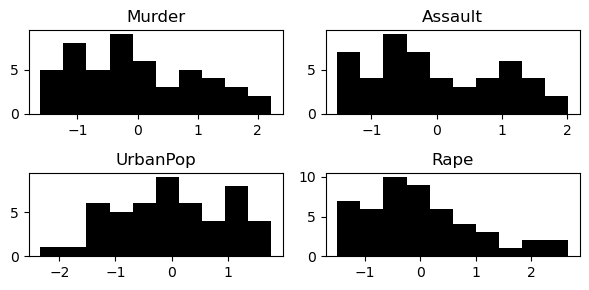

In [7]:
# Plot histograms
histograms = X.hist(color='black', grid=False, figsize=(6, 3)) 
plt.tight_layout()
plt.show()

## Correlation Analysis

In [8]:
cities = df.index
corr_df = X.corr()
labels =corr_df.columns

correlations = corr_df.corr()

C:\Users\RO\AppData\Local\Temp\ipykernel_9188\1562719765.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask_ut=np.triu(np.ones(corr_df.shape)).astype(np.bool)


<AxesSubplot:>

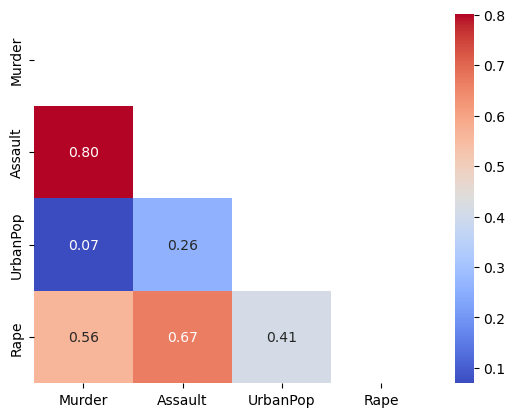

In [9]:
import seaborn as sns
mask_ut=np.triu(np.ones(corr_df.shape)).astype(np.bool)
sns.heatmap(corr_df, mask=mask_ut, cmap="coolwarm",annot=True, fmt=".2f")

The 3 crime variables are correlated with each other. As for urban population it correlates with rape relatively stronger compared to other types of crime.

## PCA

Let's get loading vectors. Loadings are interpreted as the coefficients of the linear combination of the initial variables from which the principal components are constructed. From a numerical point of view, the loadings are equal to the coordinates of the variables divided by the square root of the eigenvalue associated with the component.

In [10]:
from sklearn.decomposition import PCA
pca = PCA()
X_trans = pca.fit_transform(X)

In [11]:
pca_loadings = pd.DataFrame(PCA().fit(X).components_.T, index=df.columns, columns=['PC1', 'PC2', 'PC3', 'PC4'])
pca_loadings

,PC1,PC2,PC3,PC4
Murder,0.54,0.42,-0.34,0.65
Assault,0.58,0.19,-0.27,-0.74
UrbanPop,0.28,-0.87,-0.38,0.13
Rape,0.54,-0.17,0.82,0.09


The first component is almost equally defined by all 3 crime types.

Now let's get principal component scores for cities.

In [12]:
# Fit the PCA model and transform X to get the principal components
pca = PCA()
df_plot = pd.DataFrame(pca.fit_transform(X), columns=['PC1', 'PC2', 'PC3', 'PC4'], index=X.index)
df_plot.head()

,PC1,PC2,PC3,PC4
City,,,,
Alabama,0.99,1.13,-0.44,0.16
Alaska,1.95,1.07,2.04,-0.44
Arizona,1.76,-0.75,0.05,-0.83
Arkansas,-0.14,1.12,0.11,-0.18
California,2.52,-1.54,0.60,-0.34


Let's check the proportion of variance explained. The first component explains 62% of the variance in the data, and the second explains 25%.

In [13]:
pca.explained_variance_ratio_

array([0.62006039, 0.24744129, 0.0891408 , 0.04335752])

Let's make a plot out of it.

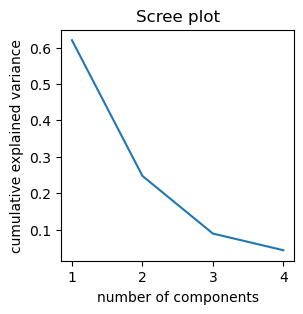

In [24]:
# Scree plot
plt.figure(figsize=(3, 3))
plt.plot([1,2,3,4], pca.explained_variance_ratio_)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title("Scree plot")
plt.show()

Text(0.5, 1.0, 'Cumulative Explained Variance')

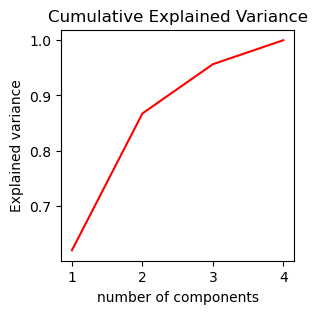

In [15]:
# Cumulative variance plot
plt.figure(figsize=(3, 3))
plt.ylabel('Explained variance')
plt.xlabel('number of components')
plt.plot(range(1,len(pca.explained_variance_ratio_ )+1),
         np.cumsum(pca.explained_variance_ratio_),
         c='red')
plt.title("Cumulative Explained Variance")

From above it is seen that a fair amount of variance (0.87) is explained by the first two principal components. Thus it is resonable to proceed with 2 components

In [16]:
std = df_plot.describe().transpose()["std"]
print(f"Standard deviation: {std.values}")

Standard deviation: [1.5908673  1.00496987 0.6031915  0.4206774 ]


In [17]:
def biplot(score,coeff,labels=None,points=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())

    fig, ax = plt.subplots()    

    ax.scatter(xs * scalex,ys * scaley,s=5)

    for i in range(0,len(xs)):
        txt = cities[i]
        ax.annotate(txt, (xs[i]* scalex, ys[i]* scaley))

    for i in range(n):
        ax.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            ax.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'r', ha = 'center', va = 'center')
        else:
            ax.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'r', ha = 'center', va = 'center')
 
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.ylim(-0.8,0.8)
    plt.xlim(-0.8,0.8)
    plt.grid()

    # Adapted from: https://ostwalprasad.github.io/machine-learning/PCA-using-python.html

California, Nevada and Florida have high score on the first component, they have high crime rates. States like North Dakota and Vermont have negative scores on the first component and also have low crime rates.

California has a high negative score on the second component, indicating a high level of urbanization, while the opposite is true for states like Mississippi and North Carolina.
States close to zero on both components, such as Indiana, have approximately average levels of both crime and urbanization.

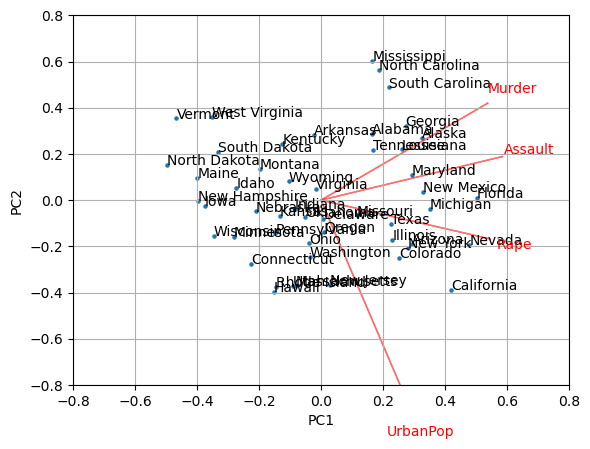

In [18]:
biplot(X_trans[:,0:2],np.transpose(pca.components_[0:2, :]),list(labels),list(cities))
plt.show()

## Hierarchical clustering


In [30]:
from scipy.cluster.hierarchy import dendrogram, linkage


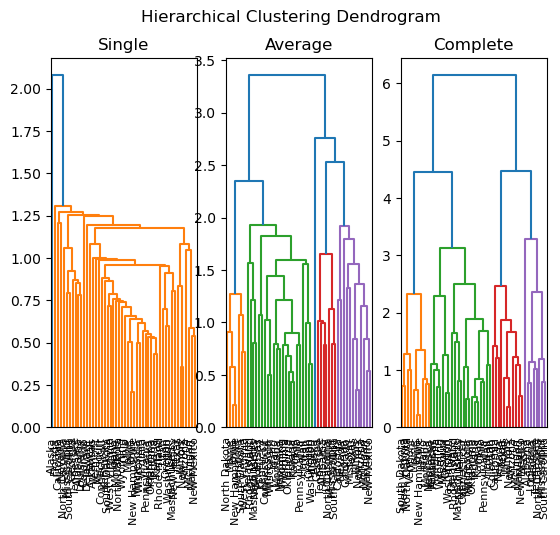

In [31]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle('Hierarchical Clustering Dendrogram')
ax1.set_title("Single")
dendrogram(linkage(df_plot, method='single'), labels=df_plot.index, ax=ax1) #change method: eg. single, average, complete...
ax2.set_title("Average")
dendrogram(linkage(df_plot, method='average'), labels=df_plot.index, ax=ax2)
ax3.set_title("Complete")
dendrogram(linkage(df_plot, method='complete'), labels=df_plot.index, ax=ax3)
plt.show()

From the dendrograms above, the complete linkage method creates the most
balanced dispersion of clusters and will therefore be the method of choice for the
rest of this analysis. A clearer dendrogram for the complete linkage method is
shown below.

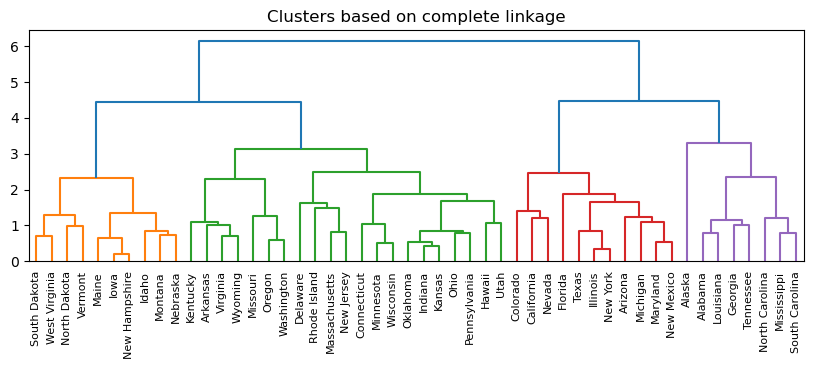

In [32]:
method='complete'
dendrogram_(method)

The clusters on the right (red and purple) correspond to states with high crime rates (they tend to have max values on PC1). The left 2 clusters are opposite having lower crime rates


### K-means clustering

For our analysis, it seems that the shape of clusters is likely to be regular based on the PCA biplot. K will be set to 4. A visualisation of the clusters is shown in the figure below.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


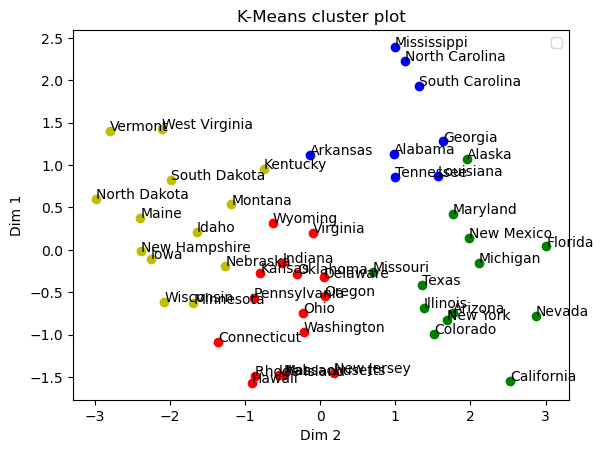

In [34]:
from sklearn.cluster import KMeans

# We extract the first two components
x = X_trans[:,0]
y = X_trans[:,1]

# Fit k-means
k=4
kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
cluster_labels = kmeans.fit_predict(df_plot)
cent = kmeans.cluster_centers_

# Plot clusters
fig, ax = plt.subplots()
colours = 'rbgy'
for i in range(0,k):
    ax.scatter(x[cluster_labels == i],y[cluster_labels == i],c = colours[i]) 

for i in range(0,len(x)):
        txt = cities[i]
        ax.annotate(txt, (x[i], y[i]))
ax.set_title("K-Means cluster plot")
ax.set_xlabel("Dim 2")
ax.set_ylabel("Dim 1")
ax.legend()

The 4 clusters based on K-means contain similar set of countries compared to dendrogram.
